In [ ]:
import torch
from nd_scaffold import GridModule

mod = GridModule(shape=(3,3,5), device='cuda:0', T=0.1)

print(mod.state)
print(mod.onehot())

mod.denoise_self()

print(mod.state)
print(mod.onehot())

mod.shift(torch.tensor([1,0,0], device='cuda:0'))

print(mod.state)
print(mod.onehot())

mod.denoise_self()

print(mod.state)
print(mod.onehot())



In [ ]:
import numpy as np
import torch
from nd_scaffold import GridScaffold, SparseMatrixBySparsityInitializer
from graph_utils import graph_scaffold, print_imgs_side_by_side
import os


def test_mnist(num_imgs=1, prefix="", relu_theta=0.5, sparsity=0.1, N_h=400, T=0.01, plot_figs=False):
    import torchvision
    from torchvision import transforms

    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: x.flatten())]
    )

    mnist = torchvision.datasets.MNIST(
        root="data", train=True, download=True, transform=transform
    )

    mnist_data = mnist.data.flatten(1).float().to("cuda")[:num_imgs]
    mnist_data = (mnist_data - mnist_data.mean()) / mnist_data.std()
    l = mnist_data.shape[0]

    shapes = [(3, 3, 5), (4, 4, 7)]
    velocities = torch.tile(torch.tensor([[1,1,1]]), (l, 1)).to("cuda")

    if False and os.path.exists("checkpoint.pt"):
        GS = GridScaffold.load("checkpoint.pt", device="cuda")
    else:
        GS = GridScaffold(
            shapes=shapes,
            N_h=N_h,
            input_size=784,
            device="cuda",
            sparse_matrix_initializer=SparseMatrixBySparsityInitializer(
                sparsity=sparsity,
                device="cuda",
            ),
            relu_theta=relu_theta,
            T=T
        )
        # GS.checkpoint("checkpoint.pt")

    # graph_scaffold(GS)

    # random_noise = torch.zeros_like(mnist_data).uniform_(-128, 128)
    noisy_mnist = mnist_data  # + random_noise
    # recalled_imgs = GS.recall(noisy_mnist)

    # for i in range(1):
    #     original_img = mnist_data[i].reshape(28, 28).cpu().numpy()
    #     noisy_img = noisy_mnist[i].reshape(28, 28).cpu().numpy()
    #     recalled_img = recalled_imgs[i].reshape(28, 28).cpu().numpy()
    #     print_imgs_side_by_side(
    #         original_img,
    #         noisy_img,
    #         recalled_img,
    #         out=f"mnist_unlearned_{i}.png",
    #         captions=["original", "noisy", "recalled"],
    #         title="Unlearned",
    #     )

    GS.learn_path(observations=mnist_data, velocities=velocities)
    recalled_imgs = GS.recall(noisy_mnist)

    if plot_figs:
        for i in range(1):
            original_img = mnist_data[i].reshape(28, 28).cpu().numpy()
            noisy_img = noisy_mnist[i].reshape(28, 28).cpu().numpy()
            recalled_img = recalled_imgs[i].reshape(28, 28).cpu().numpy()
            print_imgs_side_by_side(
                original_img,
                noisy_img,
                recalled_img,
                out=f"{prefix}mnist_learned_{i}.png",
                captions=["original", "noisy", "recalled"],
                title="Learned",
            )

    similarity = torch.nn.functional.cosine_similarity(mnist_data, GS.recall(noisy_mnist))
    return similarity

test_mnist(11, sparsity=0.99, N_h=1000, prefix="", relu_theta=0.9)

In [ ]:
from matplotlib import pyplot as plt

temperatures = [0.001, 0.03, 0.01, 0.1, 0.3, 1]
N_h = [200, 400, 600, 800, 1000]

scores = np.zeros((len(temperatures), len(N_h)))

for i, T in enumerate(temperatures):
    for j, N in enumerate(N_h):
        scores[i, j] = test_mnist(11, sparsity=0.99, N_h=N, prefix=f"T_{T}_N_{N}_").mean().item()

print(scores)

fig, ax = plt.subplots()
cax = ax.matshow(scores, cmap="viridis")

In [20]:
import pickle
with open("scores.pkl", "wb") as f:
    pickle.dump(scores, f)

In [ ]:
fig, ax = plt.subplots()
for i, T in enumerate(temperatures):
    ax.plot(N_h, scores[i], label=f"T={T}")

ax.set_xlabel("N_h")
ax.set_ylabel("Similarity")
ax.legend()
ax.legend()


In [ ]:
from vectorhash_functions import spacefillingcurve
modules = [(2,3), (3,4)]
v = spacefillingcurve(modules)

# graph walk

import matplotlib.pyplot as plt
import numpy as np

def plot_walk(v, modules):
    l2 = modules[0][0] * modules[1][0]
    l1 = modules[0][1] * modules[1][1]
    x = np.cumsum([0] + [i[0] for i in v]) % l1
    y = np.cumsum([0] + [i[1] for i in v]) % l2

    # plot arrows

    c = plt.scatter(x, y, c=range(len(x)), cmap='viridis', s=20)
    for i in range(len(x) - 1):
        plt.arrow(x[i], y[i], x[i + 1] - x[i], y[i + 1] - y[i], head_width=0.2, head_length=0.2, length_includes_head=True)
    plt.colorbar(c)

print(len(v))
plot_walk(v, modules)



In [ ]:
T = [0.01, 0.03, 0.1, 0.3, 1]
N_h = [500, 600, 700, 800, 900]

scores = np.zeros((len(T), len(N_h)))

for i, t in enumerate(T):
    for j, dim in enumerate(N_h):
        scores[i, j] = test_mnist(100, sparsity=0.99, N_h=dim, prefix=f"T_{t}_N_{dim}_", plot_figs=False).mean().item()


In [ ]:
T = [0.01, 0.03, 0.1, 0.3, 1]
N_h = [500, 600, 700, 800, 900]
fig, ax = plt.subplots()
for i, t in enumerate(T):
    ax.plot(N_h, scores[i], label=f"T={t}")

ax.set_xlabel("N_h")
ax.set_ylabel("Similarity")
ax.legend()
ax.legend()



/home/ezrahuang/miniconda3/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


imgs:     133
module shapes:  [(3, 3), (4, 4)]
N_g     :  25
N_patts :  144
N_h     :  800


AssertionError: step 0, 28/144 lost stable states, 75.50694274902344/800 (σ=8.533764839172363) avg hippocampal cells active. States lost: tensor([[  9,   9],
        [  9,  18],
        [ 18,   9],
        [ 18,  11],
        [ 32,   0],
        [ 32,   5],
        [ 45,   9],
        [ 45,  22],
        [ 54,   9],
        [ 54,  15],
        [ 63,   9],
        [ 63,  24],
        [ 72,   9],
        [ 72,  17],
        [ 81,   9],
        [ 81,  10],
        [ 99,   9],
        [ 99,  12],
        [108,   9],
        [108,  21],
        [112,   0],
        [112,   4],
        [117,   9],
        [117,  14],
        [128,   0],
        [128,   2],
        [135,   9],
        [135,  16]], device='cuda:0')

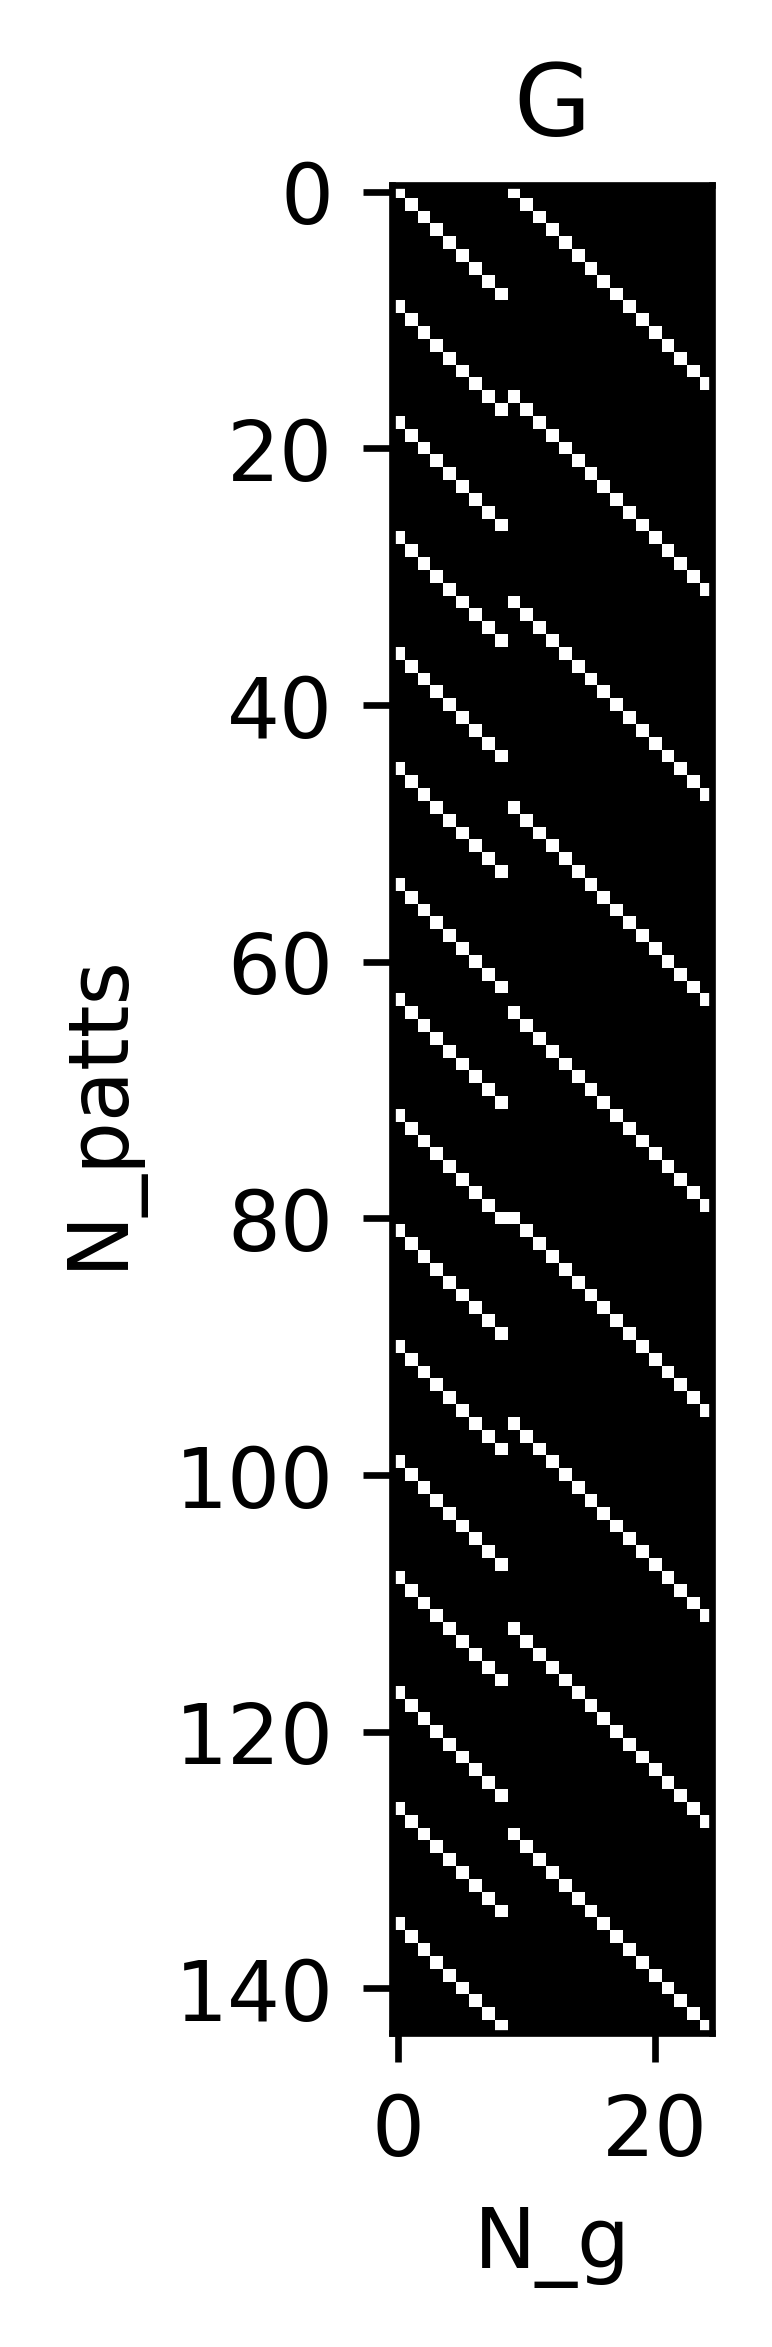

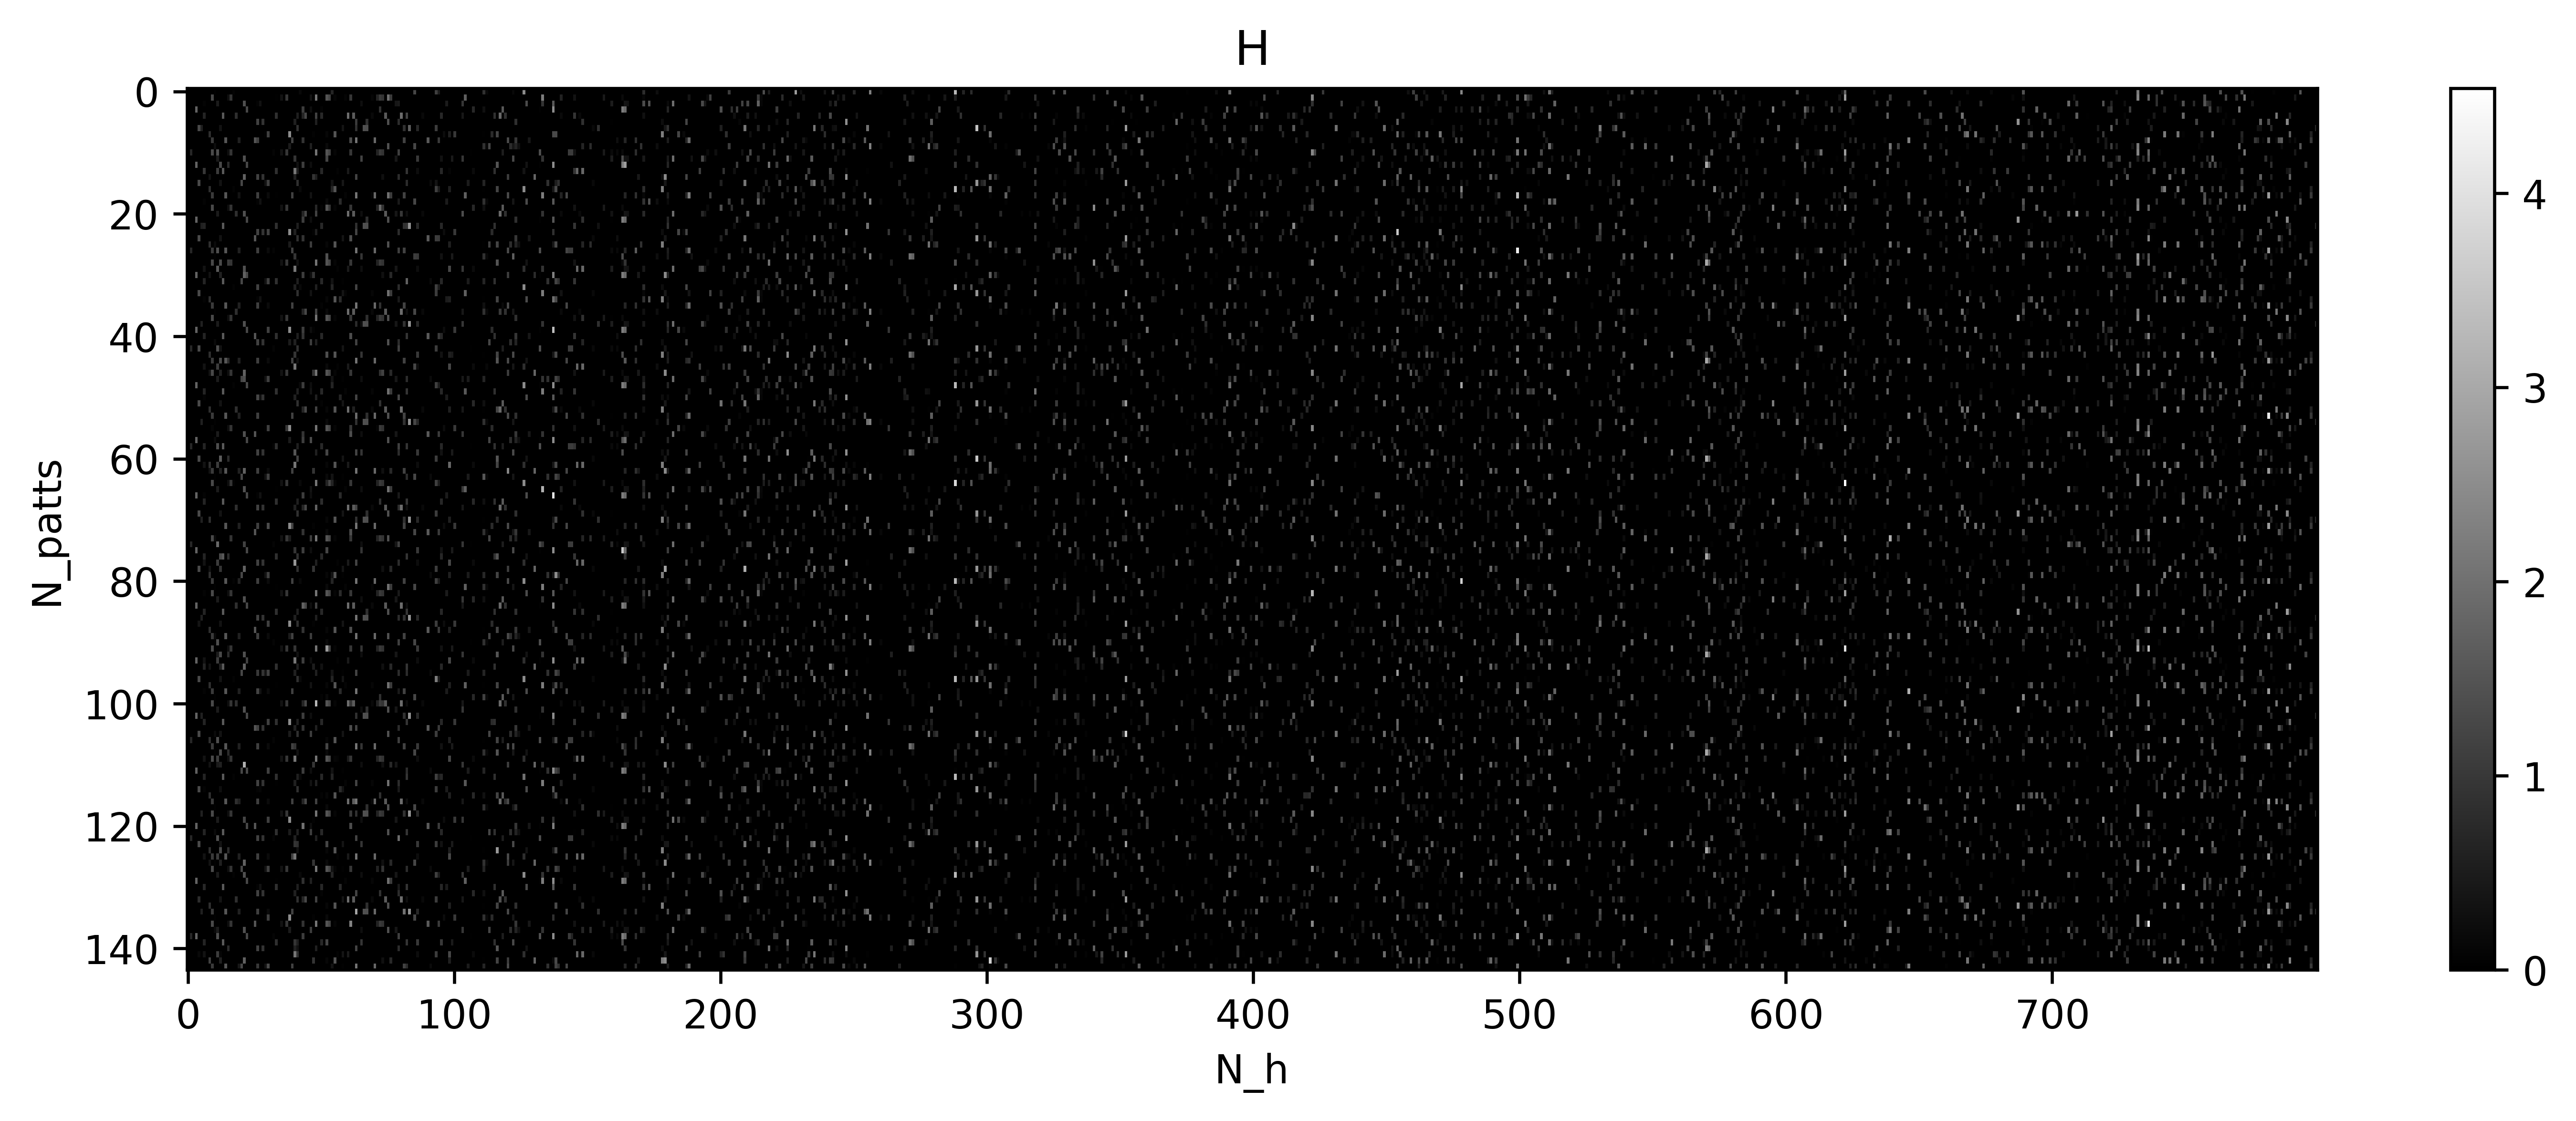

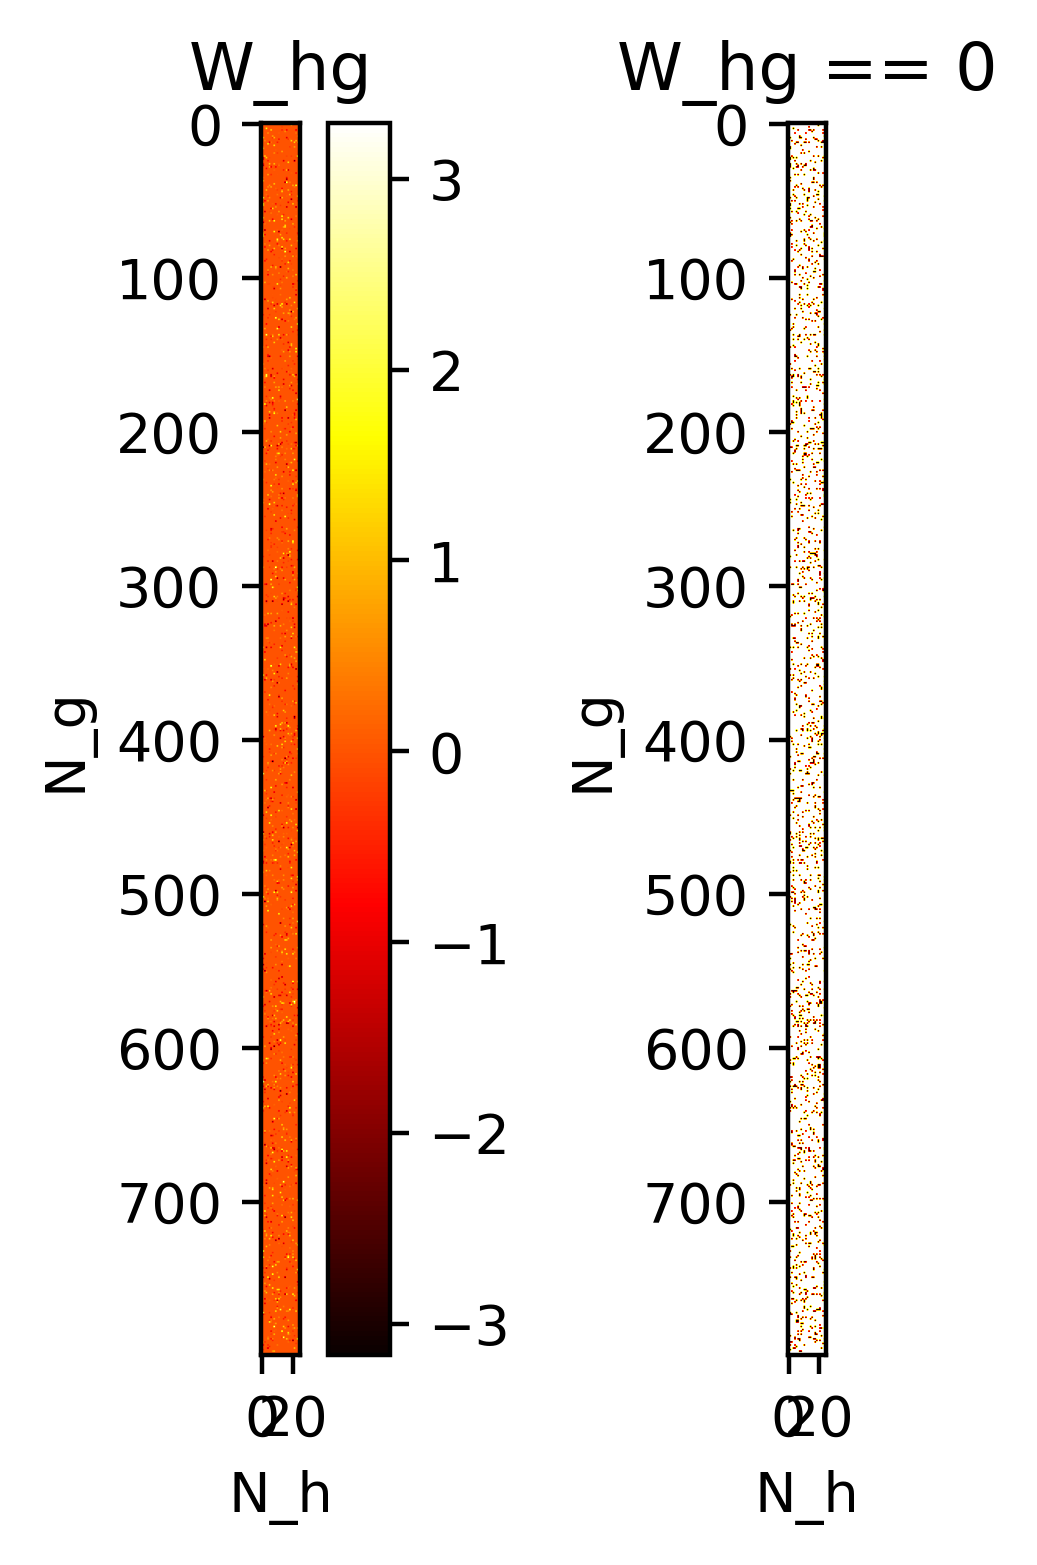

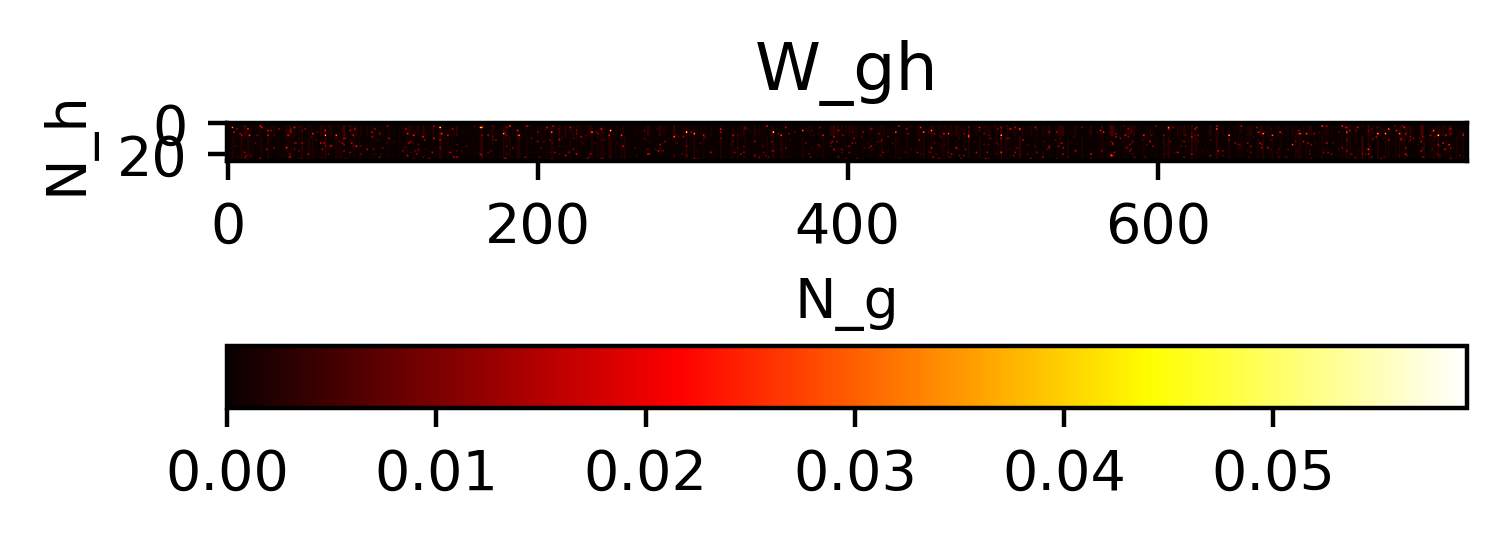

In [1]:
from nd_scaffold import GridScaffold, SparseMatrixBySparsityInitializer
import torchvision
from torchvision import transforms
from graph_utils import print_imgs_side_by_side, graph_scaffold
from vectorhash_functions import spacefillingcurve
import torch
import os

def test_mnist2(percent=1, prefix="", relu_theta=0.5, sparsity=0.1, N_h=400, T=0.01, plot_figs=False, plot_scaffold=False):
    os.makedirs("mnist_test_2", exist_ok=True)

    shapes = [(3, 3), (4, 4)]
    velocities = spacefillingcurve(shapes)
    print("imgs:    ", int(len(velocities) * percent))

    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: x.flatten())]
    )

    mnist = torchvision.datasets.MNIST(
        root="data", train=True, download=True, transform=transform
    )


    mnist_data = mnist.data.flatten(1).float().to("cuda")[int(len(velocities) * percent):]
    mnist_data = (mnist_data - mnist_data.mean()) / mnist_data.std()
    l = mnist_data.shape[0]

    if False and os.path.exists("checkpoint.pt"):
        GS = GridScaffold.load("checkpoint.pt", device="cuda")
    else:
        GS = GridScaffold(
            shapes=shapes,
            N_h=N_h,
            input_size=784,
            device="cuda",
            sparse_matrix_initializer=SparseMatrixBySparsityInitializer(
                sparsity=sparsity,
                device="cuda",
            ),
            relu_theta=relu_theta,
            T=T
        )

    if plot_scaffold:
        graph_scaffold(GS, dir="mnist_test_2")
        # GS.checkpoint("checkpoint.pt")

    # graph_scaffold(GS)

    # random_noise = torch.zeros_like(mnist_data).uniform_(-128, 128)
    noisy_mnist = mnist_data  # + random_noise
    # recalled_imgs = GS.recall(noisy_mnist)

    # for i in range(1):
    #     original_img = mnist_data[i].reshape(28, 28).cpu().numpy()
    #     noisy_img = noisy_mnist[i].reshape(28, 28).cpu().numpy()
    #     recalled_img = recalled_imgs[i].reshape(28, 28).cpu().numpy()
    #     print_imgs_side_by_side(
    #         original_img,
    #         noisy_img,
    #         recalled_img,
    #         out=f"mnist_unlearned_{i}.png",
    #         captions=["original", "noisy", "recalled"],
    #         title="Unlearned",
    #     )

    GS.learn_path(observations=mnist_data, velocities=velocities)
    recalled_imgs = GS.recall(noisy_mnist)

    if plot_figs:
        for i in range(1):
            original_img = mnist_data[i].reshape(28, 28).cpu().numpy()
            noisy_img = noisy_mnist[i].reshape(28, 28).cpu().numpy()
            recalled_img = recalled_imgs[i].reshape(28, 28).cpu().numpy()
            print_imgs_side_by_side(
                original_img,
                noisy_img,
                recalled_img,
                out=f"mnist_test_2/{prefix}mnist2_learned_{i}.png",
                captions=["original", "noisy", "recalled"],
                title="Learned",
            )

    similarity = torch.nn.functional.cosine_similarity(mnist_data, GS.recall(noisy_mnist))
    return similarity, GS

scores, GS = test_mnist2(percent=1, sparsity=0.90, N_h=800, prefix="", relu_theta=0, T=0.0000001, plot_figs=True, plot_scaffold=True)
print(scores.mean().item())

In [ ]:
import torch
from nd_scaffold import GridScaffold, SparseMatrixBySparsityInitializer
GS = GridScaffold(
    shapes=((3,3), (4,4)),
    N_h=144,
    input_size=784,
    device="cuda",
    sparse_matrix_initializer=SparseMatrixBySparsityInitializer(
        sparsity=0.1,
        device="cuda",
    ),
    relu_theta=0,
    T=0.001
)

assert torch.all(GS.G == GS.denoise(GS.grid_from_hippocampal(GS.hippocampal_from_grid(GS.G))))